<a href="https://colab.research.google.com/github/AmalKhaled28/Customer-Segmentation/blob/main/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

# Load the Dataset

In [ ]:
df = pd.read_csv('/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv')
df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


# Data Exploration


In [ ]:
df.shape

(200, 5)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [ ]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [ ]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

# Visualization

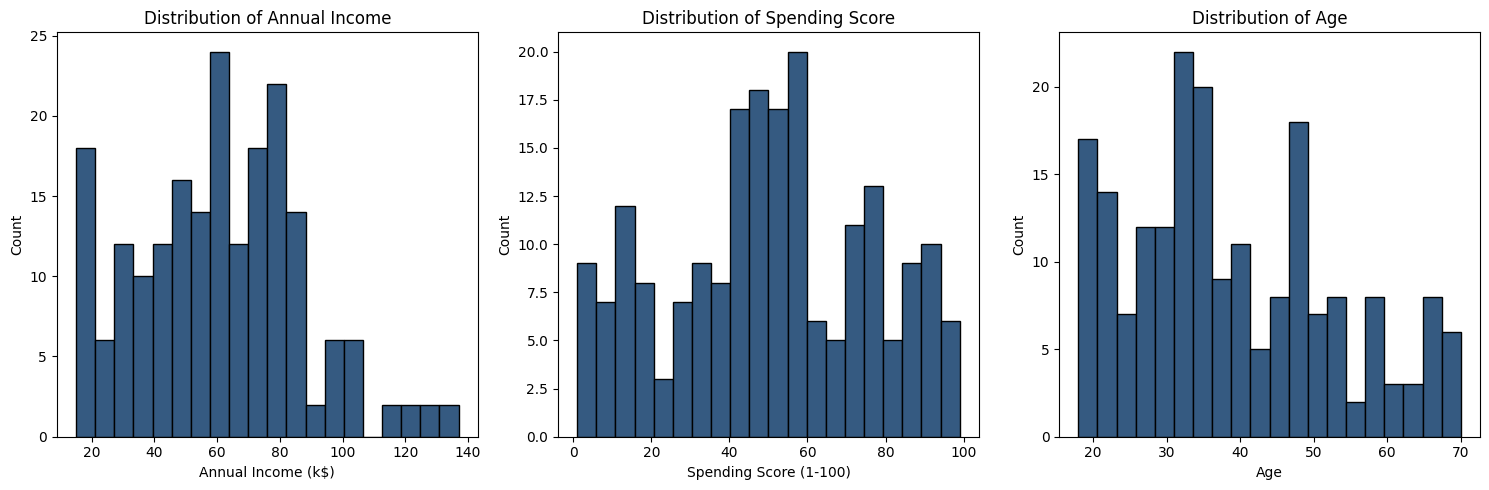

In [ ]:
# Create subplots for 3 histograms
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Annual Income
ax1.hist(df['Annual Income (k$)'], bins=20, color='#355A81', edgecolor='black')
ax1.set_title('Distribution of Annual Income')
ax1.set_xlabel('Annual Income (k$)')
ax1.set_ylabel('Count')

# Spending Score
ax2.hist(df['Spending Score (1-100)'], bins=20, color='#355A81', edgecolor='black')
ax2.set_title('Distribution of Spending Score')
ax2.set_xlabel('Spending Score (1-100)')
ax2.set_ylabel('Count')

# Age
ax3.hist(df['Age'], bins=20, color='#355A81', edgecolor='black')
ax3.set_title('Distribution of Age')
ax3.set_xlabel('Age')
ax3.set_ylabel('Count')

plt.tight_layout()
plt.show()

- Income: Two main groups (low & high).
- Spending: Balanced, peaks around 40–60.
- Age: Most customers are 30–40 years old.

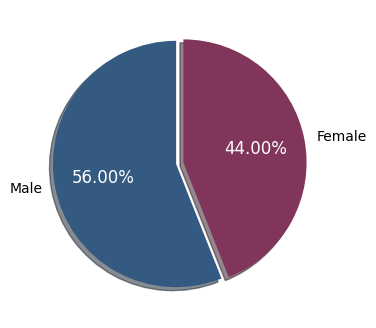

In [ ]:
values = df['Gender'].value_counts()
labels = ['Male', 'Female']
colors = ['#355A81', '#81355A']

fig, ax = plt.subplots(figsize = (4, 4), dpi = 100)
explode = (0, 0.06)

patches, texts, autotexts = ax.pie(values, labels = labels, autopct = '%1.2f%%', shadow = True,
                                   startangle = 90, explode = explode, colors=colors )

plt.setp(texts, color = 'black')
plt.setp(autotexts, size = 12, color = 'white')
autotexts[1].set_color('white')
plt.show()

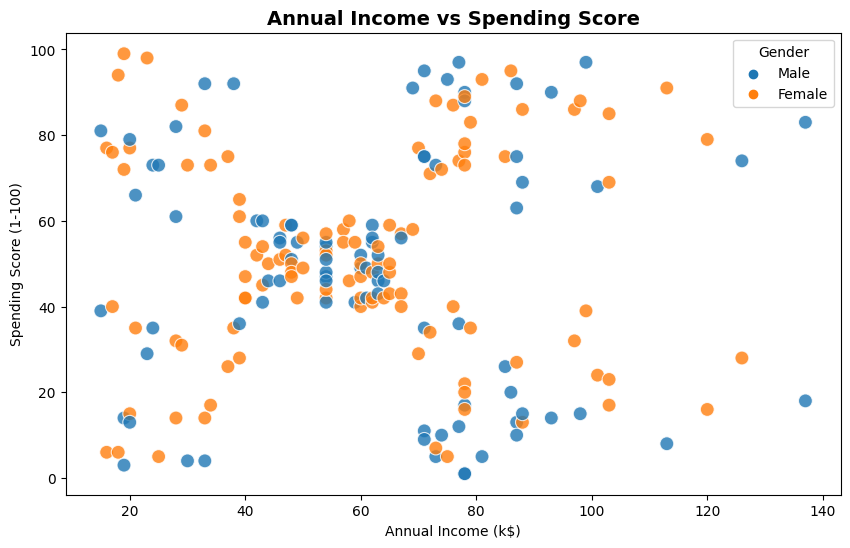

In [ ]:
# Scatter plot: Income vs Spending Score
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)',
                hue='Gender', s=100, alpha=0.8)
plt.title('Annual Income vs Spending Score', fontsize=14, fontweight='bold')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Gender')
plt.show()

- Clear 5 natural groups visible (perfect for clustering).
- Gender doesn’t strongly affect the groups.

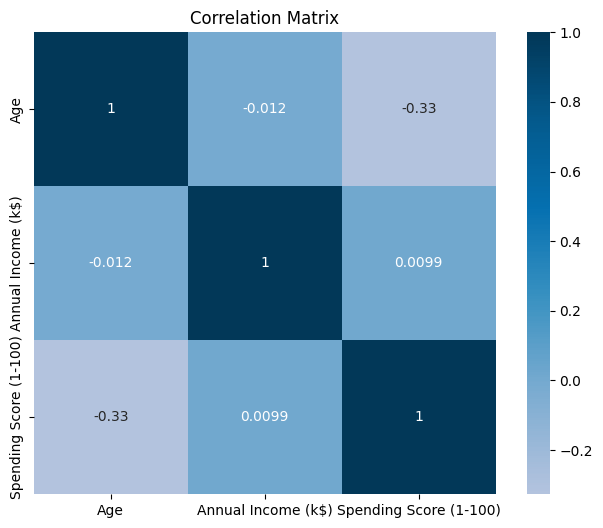

In [ ]:
plt.figure(figsize=(8, 6))
corr = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].corr()
sns.heatmap(corr, annot=True, cmap='PuBu', center=0, square=True)
plt.title('Correlation Matrix')
plt.show()

Strong negative correlation between Age and Spending → younger people spend more.

# Prepare Data for Clustering

In [ ]:
# Select features for clustering
X = df[['Annual Income (k$)', 'Spending Score (1-100)']]

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Why scaling?
- Income is in thousands, Spending is 1–100.
- Scaling makes both features equal in weight (fair clustering).

# K-Means #

# Elbow Method

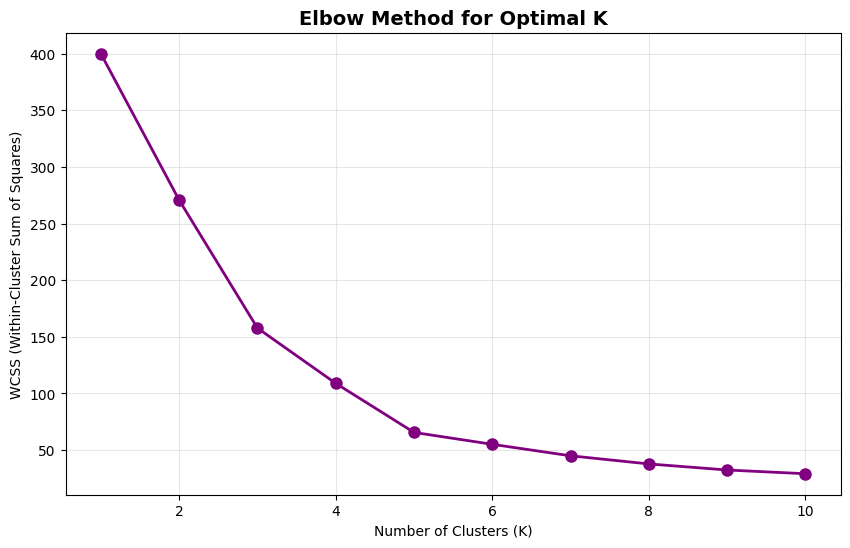

In [ ]:
# Elbow Method to find best number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', color='purple', linewidth=2, markersize=8)
plt.title('Elbow Method for Optimal K', fontsize=14, fontweight='bold')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.grid(True, alpha=0.3)
plt.show()

- The "elbow" is at k = 5 → best number of clusters.
- After k=5, improvement slows down.

In [ ]:
# Apply K-Means with 5 clusters
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42)
df['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

# Show cluster centers (in original scale)
centers = scaler.inverse_transform(kmeans.cluster_centers_)
kmeans_centers = centers  # لحفظها للاستخدام في الرسم
print("Cluster Centers (Original Scale):")
pd.DataFrame(centers, columns=['Income', 'Spending Score']).round(2)

Cluster Centers (Original Scale):


,Income,Spending Score
0,55.30,49.52
1,88.20,17.11
2,26.30,20.91
3,25.73,79.36
4,86.54,82.13


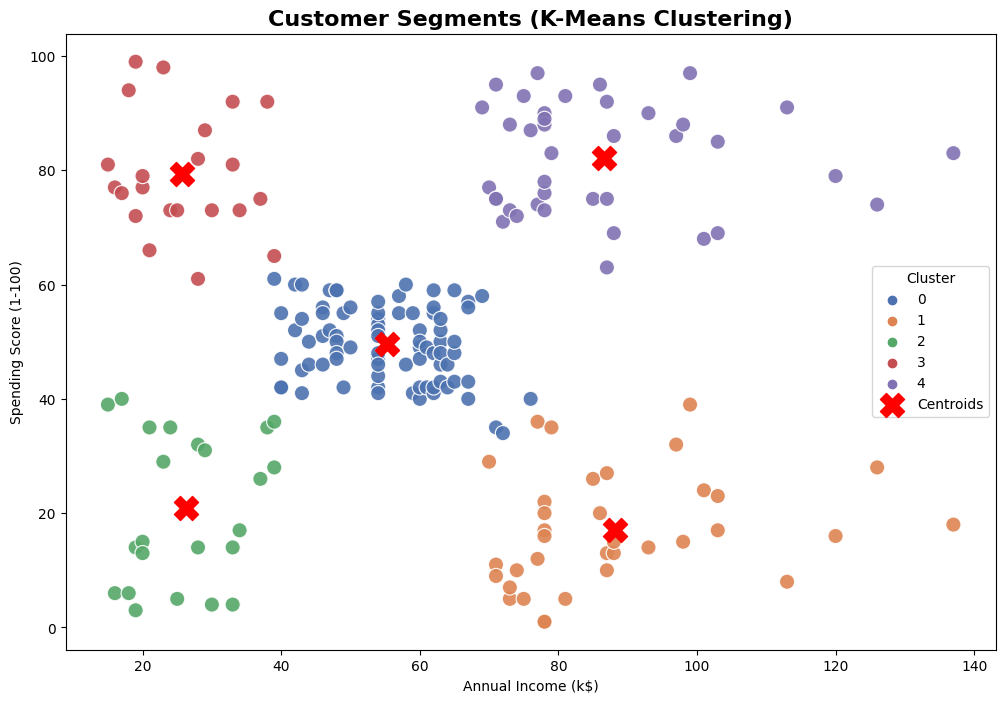

In [ ]:
# Final Cluster Visualization
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)',
                hue='KMeans_Cluster', palette='deep', s=120, alpha=0.9)

# Plot centroids
plt.scatter(centers[:, 0], centers[:, 1], s=300, c='red', marker='X', label='Centroids')
plt.title('Customer Segments (K-Means Clustering)', fontsize=16, fontweight='bold')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster')
plt.show()

# Analyze Each Cluster

In [ ]:
# Summary statistics per cluster
spending_analysis = df.groupby('KMeans_Cluster').agg({
    'Annual Income (k$)': 'mean',
    'Spending Score (1-100)': 'mean',
    'Age': 'mean',
    'CustomerID': 'count'
}).round(2)

spending_analysis.rename(columns={'CustomerID': 'Count'}, inplace=True)
spending_analysis

,Annual Income (k$),Spending Score (1-100),Age,Count
KMeans_Cluster,,,,
0,55.30,49.52,42.72,81
1,88.20,17.11,41.11,35
2,26.30,20.91,45.22,23
3,25.73,79.36,25.27,22
4,86.54,82.13,32.69,39


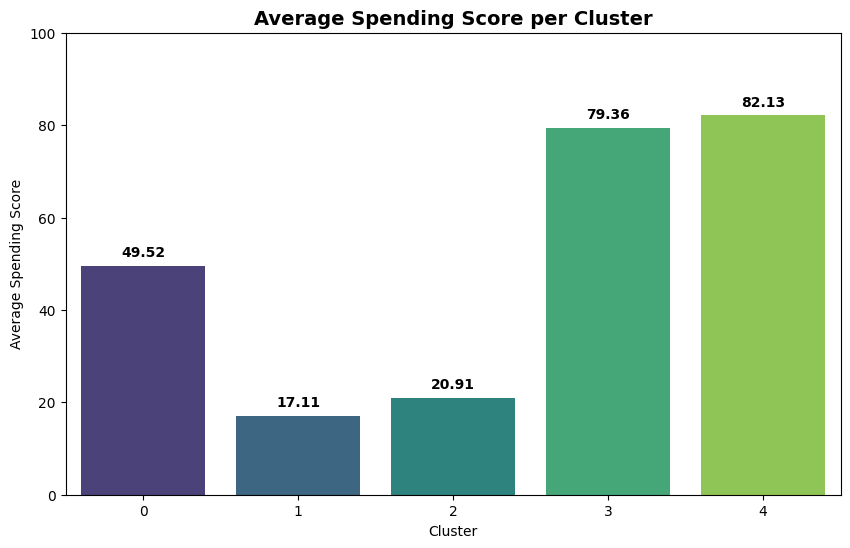

In [ ]:
# Bar chart: Average Spending
plt.figure(figsize=(10, 6))
sns.barplot(data=spending_analysis.reset_index(),
            x='KMeans_Cluster', y='Spending Score (1-100)', palette='viridis')
plt.title('Average Spending Score per Cluster', fontsize=14, fontweight='bold')
plt.xlabel('Cluster')
plt.ylabel('Average Spending Score')
plt.ylim(0, 100)

# Add value labels on bars
for i, v in enumerate(spending_analysis['Spending Score (1-100)']):
    plt.text(i, v + 2, str(v), ha='center', fontweight='bold')

plt.show()

# DBSCAN Clustering

In [ ]:
# Apply DBSCAN
dbscan = DBSCAN(eps=0.4, min_samples=5)
df['DBSCAN_Cluster'] = dbscan.fit_predict(X_scaled)

# Count clusters and noise
n_clusters = len(set(df['DBSCAN_Cluster'])) - (1 if -1 in df['DBSCAN_Cluster'] else 0)
n_noise = list(df['DBSCAN_Cluster']).count(-1)

print(f"DBSCAN found {n_clusters} clusters and {n_noise} noise points.")

DBSCAN found 5 clusters and 15 noise points.


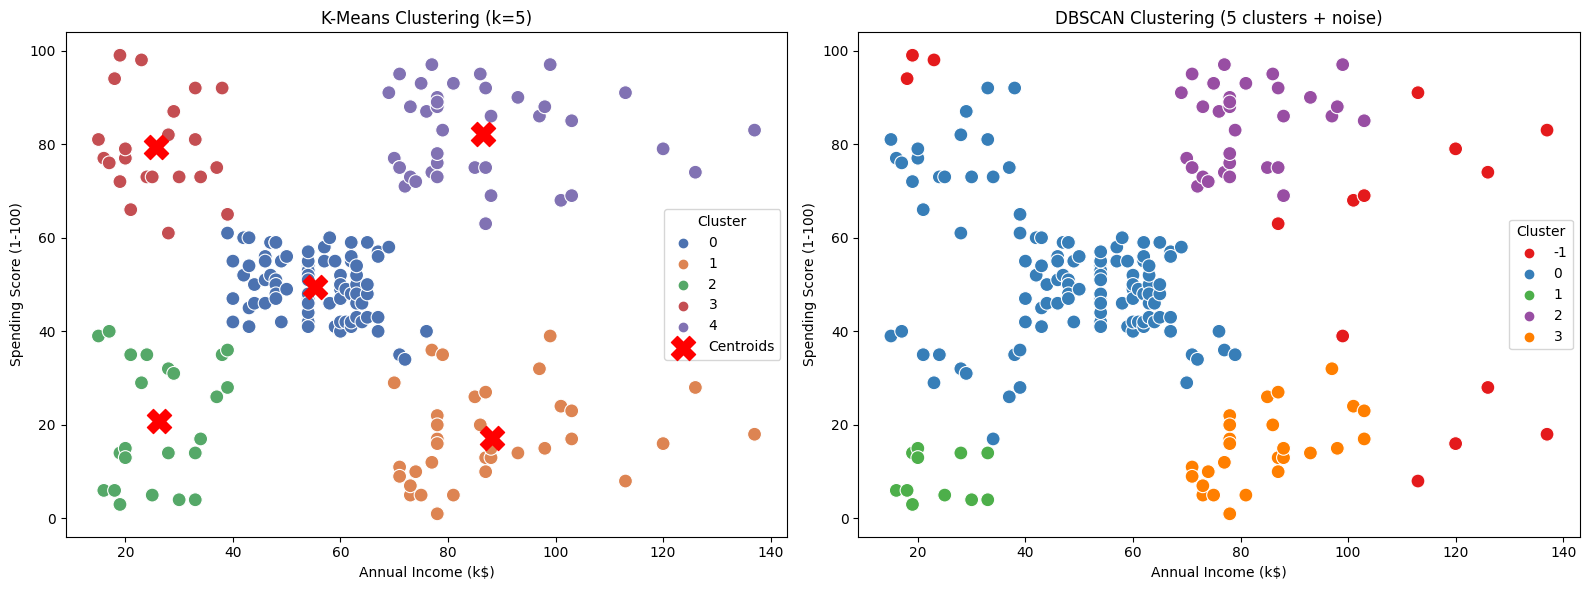

In [ ]:
# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# K-Means
sns.scatterplot(ax=ax1, data=df, x='Annual Income (k$)', y='Spending Score (1-100)',
                hue='KMeans_Cluster', palette='deep', s=100)
ax1.scatter(kmeans_centers[:, 0], kmeans_centers[:, 1], s=300, c='red', marker='X', label='Centroids')
ax1.set_title('K-Means Clustering (k=5)')
ax1.legend(title='Cluster')

# DBSCAN
sns.scatterplot(ax=ax2, data=df, x='Annual Income (k$)', y='Spending Score (1-100)',
                hue='DBSCAN_Cluster', palette='Set1', s=100)
ax2.set_title(f'DBSCAN Clustering ({n_clusters} clusters + noise)')
ax2.legend(title='Cluster')

plt.tight_layout()
plt.show()